# Import Libraries and Read Files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sk
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics, math



MET_EGNATIA        = pd.read_excel('METEOROLOGICAL_EGNATIA_2013-2017.xlsx')
MET_EPTAPIRGIO     = pd.read_excel('METEOROLOGICAL_EPTAPYRGIO_2013-2017.xlsx')
Pollution2010_2013 = pd.read_excel('Pollution_2010_2013_version_1.xlsx', sheet_name='Στ. ΕΓΝΑΤΙΑΣ',usecols="C,F")
Pollution2014_2016 = pd.read_excel('Pollution_2014_2016_version_1.xlsx', sheet_name='Στ. ΕΓΝΑΤΙΑΣ',usecols="C,F")

# Set Date as index and fix Coerce 

In [2]:
Date = list(MET_EGNATIA.loc[7:,'Station:'])
Time = list(MET_EGNATIA.loc[7:,'EGNATIAS'])
Tout = list(MET_EGNATIA.loc[7:,'Unnamed: 4'])
RH   = list(MET_EGNATIA.loc[7:,'Unnamed: 5'])
Ws   = list(MET_EPTAPIRGIO.loc[7:,'Unnamed: 2'])
Wd   = list(MET_EPTAPIRGIO.loc[7:,'Unnamed: 3'])

#PM10 lists
PM10_2010_2013=list(Pollution2010_2013.loc[:,'PM10\nμg/m3'])
PM10_2014_2016=list(Pollution2014_2016.loc[:,'PM10\nμg/m3'])

# create dataframe with data wind from  eptapirgio and data Temperature, RH, for Egnatias

myDataFrame=pd.DataFrame({'Date':Date,
                          'Time':Time,
                           'Ws'  :Ws,
                           'WD'  :Wd,
                           'Tout':Tout,
                           'RH'  :RH })

myDataFrame['Tout'] = pd.to_numeric(myDataFrame['Tout'], errors='coerce')
myDataFrame['RH'] = pd.to_numeric(myDataFrame['RH'], errors='coerce')

myDataFrame['Date']=pd.to_datetime(myDataFrame['Date'])
myDataFrame['Year']=myDataFrame['Date'].dt.year
myDataFrame['Month']=myDataFrame['Date'].dt.month
myDataFrame['Day']=myDataFrame['Date'].dt.day

myDataFrame['Time'] =  pd.to_timedelta(myDataFrame.pop('Time') + ':00')

#set index as Date
myDataFrame = myDataFrame.set_index('Date')
#set index as Date for PM10
myDataFramePM10_2013=Pollution2010_2013.set_index('Ημερο -\nμηνία')
myDataFramePM10_2014_2016=Pollution2014_2016.set_index('Ημερο -\nμηνία')

#Data for training (2013, 2014, 2015)

#2013_2015 for training
Data2013_2015 = myDataFrame.loc['01/01/13':'31/12/15']
#PM_10_2013_2015  for training set
Data2013_2015_PM10 = myDataFramePM10_2013.loc['2013-01-01':'2013-12-31']                                                                                     
Data2015_PM10 = myDataFramePM10_2014_2016.loc['2014-01-01':'2015-12-31']
Data_PM10_2013_2015=pd.concat([Data2013_2015_PM10, Data2015_PM10])
Data_PM10_2013_2015['PM10nμg/m3']=pd.to_numeric(Data_PM10_2013_2015['PM10\nμg/m3'], errors='coerce')
Data_PM10_2013_2015=Data_PM10_2013_2015.reset_index(inplace=False)

#Data for varification (2016)
Data2016 = myDataFrame.loc['01/01/16':'31/12/16']
#PM10 for varification (2016)
Data2016_PM10 = myDataFramePM10_2014_2016.loc['2016-01-01':'2016-12-31']
Data2016_PM10=Data2016_PM10.reset_index(inplace=False)

# Prepare Data as Time Series and drop NAN

In [3]:
#Prepare Training set
Data2013_2015_WD_Ws=[]
Data2013_2015_WD_Ws=pd.DataFrame(Data2013_2015)
Data2013_2015_WD_Ws=Data2013_2015_WD_Ws.reset_index(inplace=False)
Data2013_2015_WD_Ws=Data2013_2015_WD_Ws.loc[Data2013_2015_WD_Ws.Time=='14:00:00', :]
Data2013_2015_WD_Ws.index = np.arange(len(Data2013_2015_WD_Ws))

Data2013_2015_RH_Tout=[]
Data2013_2015_RH_Tout= pd.DataFrame(Data2013_2015)
Data2013_2015_RH_Tout=Data2013_2015_RH_Tout.groupby('Date')[['Tout','RH']].mean() 
Data2013_2015_RH_Tout=Data2013_2015_RH_Tout.reset_index(inplace=False)

Data2013_2015_tr_set=[]
Data2013_2015_tr_set=pd.DataFrame(Data2013_2015_tr_set)
Data2013_2015_tr_set['Date']=Data2013_2015_RH_Tout['Date']
Data2013_2015_tr_set['Ws']=Data2013_2015_WD_Ws['Ws']
Data2013_2015_tr_set['WD']=Data2013_2015_WD_Ws['WD']
Data2013_2015_tr_set['Tout']=Data2013_2015_RH_Tout['Tout']
Data2013_2015_tr_set['RH']=Data2013_2015_RH_Tout['RH']
Data2013_2015_tr_set['PM10nμg/m3_PreDay'] = Data_PM10_2013_2015['PM10nμg/m3'].shift(1)
Data2013_2015_tr_set['PM10nμg/m3']=Data_PM10_2013_2015['PM10nμg/m3']
Data2013_2015_tr_set.index = np.arange(len(Data_PM10_2013_2015))

#prepare test set 2016
Data2016_WD_Ws=[]
Data2016_WD_Ws=pd.DataFrame(Data2016)
Data2016_WD_Ws=Data2016_WD_Ws.reset_index(inplace=False)
Data2016_WD_Ws=Data2016_WD_Ws.loc[Data2016_WD_Ws.Time=='14:00:00', :]
Data2016_WD_Ws.index = np.arange(len(Data2016_WD_Ws))

Data2016_RH_Tout=[]
Data2016_RH_Tout= pd.DataFrame(Data2016)
Data2016_RH_Tout=Data2016_RH_Tout.groupby('Date')[['Tout','RH']].mean() 
Data2016_RH_Tout=Data2016_RH_Tout.reset_index(inplace=False)

Data2016_varif_set=[]
Data2016_varif_set=pd.DataFrame(Data2016_varif_set)
Data2016_varif_set['Date']=Data2016_RH_Tout['Date']
Data2016_varif_set['Ws']=Data2016_WD_Ws['Ws']
Data2016_varif_set['WD']=Data2016_WD_Ws['WD']
Data2016_varif_set['Tout']=Data2016_RH_Tout['Tout']
Data2016_varif_set['RH']=Data2016_RH_Tout['RH']
Data2016_varif_set['PM10nμg/m3_PreDay']=Data2016_PM10['PM10\nμg/m3'].shift(1).astype(float)
Data2016_varif_set['PM10nμg/m3']=Data2016_PM10['PM10\nμg/m3'].astype(float)   
Data2016_varif_set.index = np.arange(len(Data2016_PM10))

In [4]:
Data2013_2015_tr_set=Data2013_2015_tr_set.dropna()  
Data2013_2015_tr_set = Data2013_2015_tr_set.reset_index(drop=True)

Data2016_varif_set=Data2016_varif_set.dropna() 
Data2016_varif_set=Data2016_varif_set.reset_index(drop=True) 


In [5]:
data2013_2016=pd.concat([Data2013_2015_tr_set,Data2016_varif_set],ignore_index=True)

# Check for Any Negative value

In [6]:
data2013_2016.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ws,1408.0,2.024361,1.547540,0.000000,1.000000,1.600,2.500000,9.100000
WD,1408.0,218.991477,72.027999,0.000000,185.750000,219.000,256.000000,360.000000
Tout,1408.0,17.945439,7.457015,-1.083333,11.870833,17.625,24.478125,32.941667
RH,1408.0,59.519868,13.048301,29.250000,50.083333,58.875,69.135417,93.250000
PM10nμg/m3_PreDay,1408.0,47.639205,19.173852,18.000000,35.000000,42.000,55.000000,171.000000
PM10nμg/m3,1408.0,47.574574,19.122397,18.000000,35.000000,42.000,54.250000,171.000000


# Transform Wind Direction to Sin

In [7]:
#2013-2016
#transform from Deg to Rad
data2013_2016[['WD']] = data2013_2016[['WD']]*np.pi/180
#Calculate Sin for Weed Direction
data2013_2016[['WD']]=np.sin(data2013_2016[['WD']])

# Heatmap

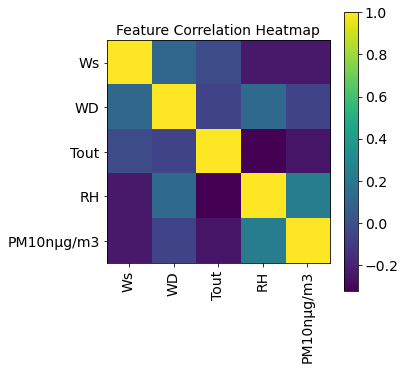

In [8]:
def show_heatmap(data):
    plt.rcParams['figure.figsize'] = (5, 5)
    plt.rcParams['axes.grid'] = False
    plt.matshow(data.corr())
    plt.xticks(np.arange(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(np.arange(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
    
data2013_2016_hm= data2013_2016.iloc[:,[1,2,3,4,6]] .astype(float)  
show_heatmap(data2013_2016_hm)

# Wind Speed, Wind Direction, Temperatur, RH, PM10 vs Date 2013 - 2016

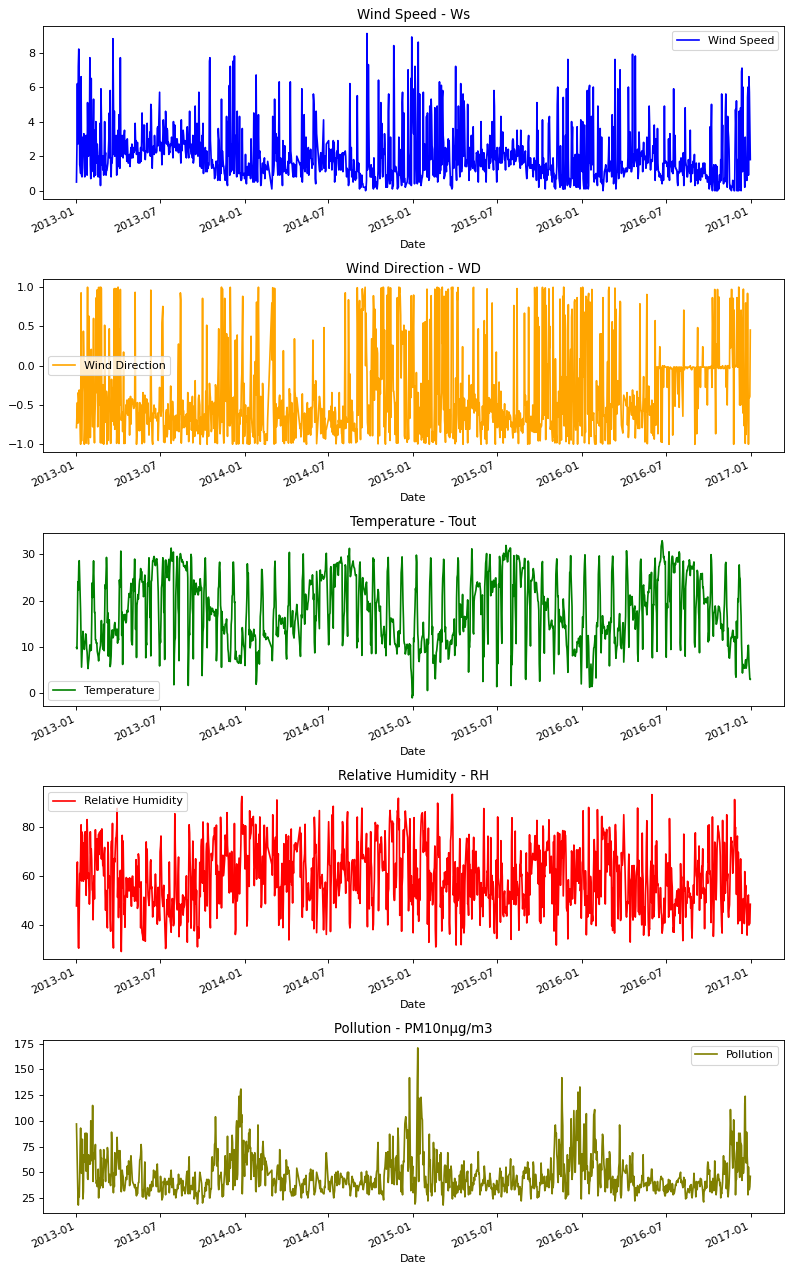

In [9]:
titles = ['Wind Speed','Wind Direction','Temperature','Relative Humidity','Pollution']

colors = ["blue","orange","green","red","olive"]

feature_keys = ['Ws','WD','Tout','RH','PM10nμg/m3']
date_time_key = 'Date'

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 16), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(data2013_2016)

# Boxplot Before Normalization  

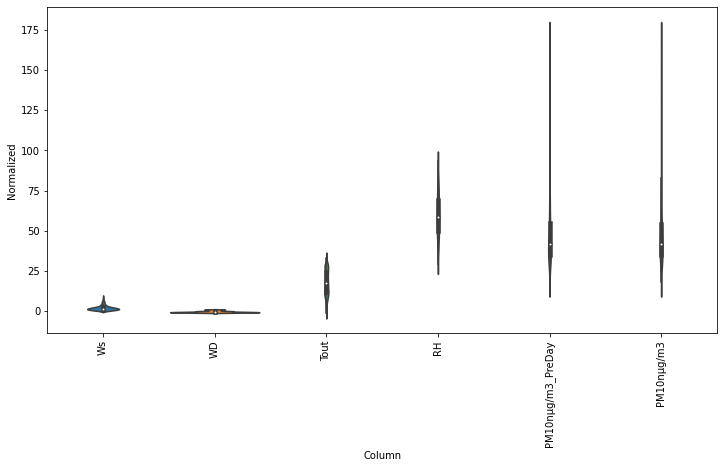

In [10]:
#Before Normalization
import seaborn as sns
data2013_2016=data2013_2016[['Ws', 'WD', 'Tout' ,'RH','PM10nμg/m3_PreDay','PM10nμg/m3']].astype(float)
df_std = data2013_2016
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data2013_2016.keys(), rotation=90)

# Boxplot After Normalization

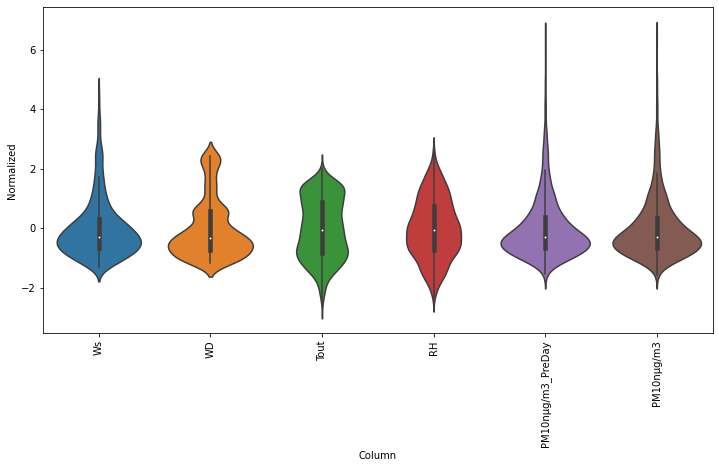

In [11]:
#Normalization
data2013_2016_mean=data2013_2016.mean()
data2013_2016_std=data2013_2016.std()

data2013_2016 = (data2013_2016 - data2013_2016_mean) / data2013_2016_std
df_std = data2013_2016
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data2013_2016.keys(), rotation=90)

# Split Data -Train set - Test set

In [12]:
train_set=data2013_2016[:len(Data2013_2015_tr_set)] 
test_set=data2013_2016[len(Data2013_2015_tr_set):]
test_set = test_set.reset_index(drop=True)

# OLS Regression Fit

In [13]:
#linear regrassion OLS

train_x=train_set[['Ws','WD','RH','Tout','PM10nμg/m3_PreDay']]
train_y=train_set[['PM10nμg/m3']]

train_x_ = sm.add_constant(train_x)


model = sm.OLS(train_y, train_x_)
fitted=model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:             PM10nμg/m3   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     252.0
Date:                Sun, 21 Mar 2021   Prob (F-statistic):          1.37e-176
Time:                        18:15:48   Log-Likelihood:                -1097.1
No. Observations:                1049   AIC:                             2206.
Df Residuals:                    1043   BIC:                             2236.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0100      0.02

# Predict for Train Set

In [14]:
y_pred_t = fitted.predict(train_x_)

# Calculate: Bias, MAE, MSE, RMSE for Train set

In [15]:
# predict for train
bias=(train_y['PM10nμg/m3'] - y_pred_t).mean()
print("\n")
print("Mean absolute error train (MAE):      %f" % sklearn.metrics.mean_absolute_error(train_y,y_pred_t))
print("Mean squared error train (MSE):       %f" % sklearn.metrics.mean_squared_error(train_y,y_pred_t))
print("Root mean squared error train (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(train_y,y_pred_t)))
print("R square (R^2) train:                 %f" % fitted.rsquared)
print("bias:                                 %.32f"% bias)



Mean absolute error train (MAE):      0.498843
Mean squared error train (MSE):       0.474139
Root mean squared error train (RMSE): 0.688578
R square (R^2) train:                 0.547158
bias:                                 0.00000000000000004572129138589777


In [16]:
y_pred_t=data2013_2016_std['PM10nμg/m3']*y_pred_t+data2013_2016_mean['PM10nμg/m3']
y_train_b=data2013_2016_std['PM10nμg/m3']*train_y+data2013_2016_mean['PM10nμg/m3']

# Scatter Comparison Plot  for Train Set

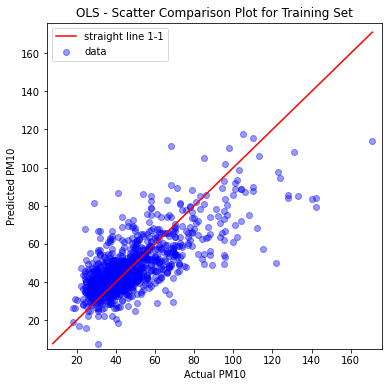

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train_b, y_pred_t, alpha=0.4, color='blue',label='data')

x_values = [y_pred_t.min(),y_train_b['PM10nμg/m3'].max()]
y_values = [y_pred_t.min(),y_train_b['PM10nμg/m3'].max()]
plt.plot(x_values, y_values,color='red',label='straight line 1-1')
plt.legend()

ax.set_xlim(5,y_train_b['PM10nμg/m3'].max()+5)
ax.set_ylim(5,y_train_b['PM10nμg/m3'].max()+5)
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.title('OLS - Scatter Comparison Plot for Training Set')
plt.show()

# Predict for Test set and Calculate: Bias, MAE, MSE, RMSE  

In [18]:
# predict for test
test_x=test_set[['Ws','WD','RH','Tout','PM10nμg/m3_PreDay']]
test_y=test_set[['PM10nμg/m3']]

test_x_ = sm.add_constant(test_x)

y_pred = fitted.predict(test_x_)
bias=(test_y['PM10nμg/m3'] - y_pred).mean()

print("\n")
print("Mean absolute error test (MAE):      %f" % sklearn.metrics.mean_absolute_error(test_y,y_pred))
print("Mean squared error test (MSE):       %f" % sklearn.metrics.mean_squared_error(test_y,y_pred))
print("Root mean squared error test (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(test_y,y_pred)))
print("R square test (R^2):                 %f" % sklearn.metrics.r2_score(test_y,y_pred))
print("bias:                                %f" % bias)



Mean absolute error test (MAE):      0.466755
Mean squared error test (MSE):       0.407536
Root mean squared error test (RMSE): 0.638385
R square test (R^2):                 0.522627
bias:                                -0.039261


In [19]:
y_pred=data2013_2016_std['PM10nμg/m3']*y_pred+data2013_2016_mean['PM10nμg/m3']
y_test_b=data2013_2016_std['PM10nμg/m3']*test_y+data2013_2016_mean['PM10nμg/m3']

# Scatter Comparison Plot for Test set 

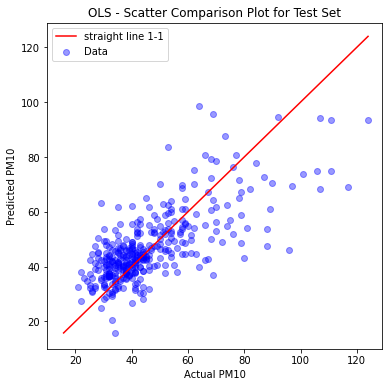

In [20]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test_b, y_pred, alpha=0.4, color='blue',label='Data')


x_values = [y_pred.min(),y_test_b['PM10nμg/m3'].max()]
y_values = [y_pred.min(),y_test_b['PM10nμg/m3'].max()]
plt.plot(x_values, y_values,color='red',label='straight line 1-1')

ax.set_xlim(10,y_test_b['PM10nμg/m3'].max()+5)
ax.set_ylim(10,y_test_b['PM10nμg/m3'].max()+5)
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.title('OLS - Scatter Comparison Plot for Test Set')
plt.legend()
plt.show()